In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!python --version

In [ ]:
# clone glow
!git clone https://github.com/y0ast/Glow-PyTorch.git
%cd Glow-PyTorch/

# Imports

In [1]:
# imports
import json
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set()

from datasets import get_CIFAR10, get_SVHN, postprocess
from model import Glow
from torchvision import datasets, transforms, utils, models
from pathlib import Path
from sklearn.decomposition import PCA

# initialize torch with cuda
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('Initialize a GPU session')

Initialize a GPU session


D:\InstalledSoftware\Anaconda3\envs\deepLearning\lib\site-packages\torch\cuda\__init__.py:82: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# download the pretrained model files
%%capture
if not os.path.isdir('glow'):
  !wget https://www.cs.ox.ac.uk/people/joost.vanamersfoort/glow.zip
  !unzip glow.zip

In [ ]:
output_folder = 'glow/'
model_name = 'glow_affine_coupling.pt'

with open(output_folder + 'hparams.json') as json_file:  
    hparams = json.load(json_file)
    
image_shape, num_classes, _, test_cifar = get_CIFAR10(hparams['augment'], hparams['dataroot'], download=True)
image_shape, num_classes, _, test_svhn = get_SVHN(hparams['augment'], hparams['dataroot'], download=True)


model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(output_folder + model_name))
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

In [ ]:
def compute_nll(dataset, model):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, num_workers=6)
    
    nlls = []
    for x,y in dataloader:
        x = x.to(device)
        
        if hparams['y_condition']:
            y = y.to(device)
        else:
            y = None
        
        with torch.no_grad():
            _, nll, _ = model(x, y_onehot=y)
            nlls.append(nll)
        
    return torch.cat(nlls).cpu()

In [ ]:
cifar_nll = compute_nll(test_cifar, model)
svhn_nll = compute_nll(test_svhn, model)

print("CIFAR NLL", torch.mean(cifar_nll))
print("SVHN NLL", torch.mean(svhn_nll))

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Histogram Glow - trained on CIFAR10")
plt.xlabel("Negative bits per dimension")
plt.hist(-svhn_nll.numpy(), label="SVHN", density=True, bins=30)
plt.hist(-cifar_nll.numpy(), label="CIFAR10", density=True, bins=50)
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DLGraphs/Likelihood.png',dpi=600)
plt.show()

# Histogram of Data Statistics

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_cifar10 = datasets.CIFAR10(
    root = 'F:\\dl\\project\\data_noTransform\\data\\CIFAR10',
    train=True,
    transform=transform,
    download=True
    )

test_cifar10 = datasets.CIFAR10(
    root = 'F:\\dl\\project\\data_noTransform\\data\\CIFAR10',
    train=False,
    transform=transform,
    download=False
    )

train_cifar100 = datasets.CIFAR100(
    root = 'F:\\dl\\project\\data_noTransform\\data\\CIFAR100',
    train=True,
    transform=transform,
    download=True
    )
test_cifar100 = datasets.CIFAR100(
    root = 'F:\\dl\\project\\data_noTransform\\data\\CIFAR100',
    train=False,
    transform=transform,
    download=True
    )

train_svhn = datasets.SVHN(
    root = 'F:\\dl\\project\\data_noTransform\\data\\SVHN',
    split="train",
    transform=transform,
    download=True
    )

test_svhn = datasets.SVHN(
    root = 'F:\\dl\\project\\data_noTransform\\data\\SVHN',
    split="test",
    transform=transform,
    download=True
    )


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: F:\dl\project\data_noTransform\data\SVHN\train_32x32.mat
Using downloaded and verified file: F:\dl\project\data_noTransform\data\SVHN\test_32x32.mat


In [ ]:
# Reference: https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560

def getDatasetStats(dataLoader=None):
  mean = 0.
  std = 0.
  
  iterCount = 0
  datasetValues = {}

  for data, _ in dataLoader:
    if iterCount == 0:
      datasetValues['currDataset'] = data.clone()
    else:
      datasetValues['currDataset'] = torch.cat((datasetValues['currDataset'], data.clone()), 0)
  
    iterCount += 1

  datasetValues['currDataset'] = (datasetValues['currDataset'] - datasetValues['currDataset'].min())/(datasetValues['currDataset'].max() - datasetValues['currDataset'].min())

  data = datasetValues['currDataset']

  batch_samples = data.size(0) # batch size (the last batch can have smaller size!)
  data = data.view(batch_samples, -1)
  mean = data.sum(0)

  mean = mean/batch_samples

  batch_samples = data.size(0) # batch size (the last batch can have smaller size!)
  data = data.view(batch_samples, -1)
  data -= mean
  std += (data**2).sum(0) 

  std = std/(batch_samples-1)

  return mean, std

combined_svhn = torch.utils.data.ConcatDataset([train_svhn, test_svhn])
dataloader = torch.utils.data.DataLoader(combined_svhn, batch_size=512)
mean_svhn, std_svhn = getDatasetStats(dataloader)

combined_cifar10 = torch.utils.data.ConcatDataset([train_cifar10, test_cifar10])
dataloader = torch.utils.data.DataLoader(combined_cifar10, batch_size=512)
mean_cifar10, std_cifar10 = getDatasetStats(dataloader)

combined_cifar100 = torch.utils.data.ConcatDataset([train_cifar100, test_cifar100])
dataloader = torch.utils.data.DataLoader(combined_cifar100, batch_size=512)
mean_cifar100, std_cifar100 = getDatasetStats(dataloader)


In [ ]:
df_means = pd.DataFrame({'SVHN':mean_svhn.tolist(),
                         'Cifar10':mean_cifar10.tolist(),
                         'Cifar100':mean_cifar100.tolist()})

In [ ]:
df_std = pd.DataFrame({'SVHN':std_svhn.tolist(),
                       'Cifar10':std_cifar10.tolist(),
                       'Cifar100':std_cifar100.tolist()})

In [ ]:
sns.displot(df_means, kind='kde')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DLGraphs/DataMeanScaled.png',dpi=600)
plt.show()

In [ ]:
sns.displot(df_std, kind='kde')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DLGraphs/DataStDeviationScaled.png',dpi=600)
plt.show()

# Autoencoder

In [ ]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = torch.nn.Linear(
            in_features=kwargs["input_shape"], out_features=1024
        )
        self.encoder_output_layer = torch.nn.Linear(
            in_features=1024, out_features=512
        )
        self.decoder_hidden_layer = torch.nn.Linear(
            in_features=512, out_features=1024
        )
        self.decoder_output_layer = torch.nn.Linear(
            in_features=1024, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed


In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load it to the specified device, either gpu or cpu
model = AutoEncoder(input_shape=3072).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = torch.nn.MSELoss()

In [ ]:
def trainEncoder(dataLoader, epochs):
  for epoch in range(epochs):
      loss = 0
      for batch_features, _ in dataLoader:
          
          # load it to the active device
          batch_features = batch_features.view(-1, 3072).to(device)
          
          # reset the gradients back to zero
          # PyTorch accumulates gradients on subsequent backward passes
          optimizer.zero_grad()
          
          # compute reconstructions
          outputs = model(batch_features)
          
          # compute training reconstruction loss
          train_loss = criterion(outputs, batch_features)
          
          # compute accumulated gradients
          train_loss.backward()
          
          # perform parameter update based on current gradients
          optimizer.step()
          
          # add the mini-batch training loss to epoch loss
          loss += train_loss.item()
      
      # compute the epoch training loss
      loss = loss / len(dataLoader)
      
      # display the epoch training loss
      print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

In [ ]:
# dataloader = torch.utils.data.DataLoader(train_svhn, batch_size=512)

# dataloader = torch.utils.data.DataLoader(train_cifar10, batch_size=512)

dataloader = torch.utils.data.DataLoader(train_cifar100, batch_size=512)

trainEncoder(dataloader, 20)

In [ ]:
# Store activations

# activation = {}

In [ ]:
count = 0

In [ ]:
# Create hook to get values

def get_activation(name):
    def hook(model, input, output):
      global count
      if count == 0:
        activation[name] = output.clone()
      else:
        activation[name] = torch.cat((activation[name], output.clone()), 0)
      count += 1
    return hook

In [ ]:
encoderLatent = torch
model.encoder_output_layer.register_forward_hook(get_activation('cifar100'))

In [ ]:
def getLatentRep(dataLoader):
  for batch_features, _ in dataLoader:
      
      # load it to the active device
      batch_features = batch_features.view(-1, 3072).to(device)
      
      # compute reconstructions
      outputs = model(batch_features)

combined_svhn = torch.utils.data.ConcatDataset([train_svhn, test_svhn])
dataloader = torch.utils.data.DataLoader(combined_svhn, batch_size=512)
getLatentRep(dataloader)

# combined_cifar10 = torch.utils.data.ConcatDataset([train_cifar10, test_cifar10])
# dataloader = torch.utils.data.DataLoader(combined_cifar10, batch_size=512)
# getLatentRep(dataloader)

# combined_cifar100 = torch.utils.data.ConcatDataset([train_cifar100, test_cifar100])
# dataloader = torch.utils.data.DataLoader(combined_cifar100, batch_size=512)
# getLatentRep(dataloader)

In [ ]:
def getLatentRepStats(name):
  mean = 0.
  std = 0.

  scaled = (activation[name] - activation[name].min())/(activation[name].max() - activation[name].min())

  batch_samples = scaled.size(0) # batch size (the last batch can have smaller size!)
  scaled = scaled.view(batch_samples, -1)
  mean = scaled.sum(0)

  mean = mean/batch_samples

  batch_samples = scaled.size(0) # batch size (the last batch can have smaller size!)
  scaled = scaled.view(batch_samples, -1)
  scaled -= mean
  std += (scaled**2).sum(0) 

  std = std/(batch_samples-1)

  return mean, std

In [ ]:
mean_svhn, std_svhn = getLatentRepStats('svhn')
mean_cifar10, std_cifar10 = getLatentRepStats('cifar10')
mean_cifar100, std_cifar100 = getLatentRepStats('cifar100')

### Histogram of Latent Representation Statistics (Autoencoder)

In [ ]:
df_means = pd.DataFrame({'SVHN':mean_svhn.tolist(),
                         'Cifar10':mean_cifar10.tolist(),
                         'Cifar100':mean_cifar100.tolist()})

In [ ]:
df_std = pd.DataFrame({'SVHN':std_svhn.tolist(),
                       'Cifar10':std_cifar10.tolist(),
                       'Cifar100':std_cifar100.tolist()})

In [ ]:
sns.displot(df_means, kind='kde')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DLGraphs/AEMeanScaled.png',dpi=600)
plt.show()

In [ ]:
sns.displot(df_std, kind='kde')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/DLGraphs/AEStDeviationScaled.png',dpi=600)
plt.show()

# PCA

In [ ]:
cat_svhn = torch.cat((torch.tensor(train_svhn.data), torch.tensor(test_svhn.data)),0)*1.0
cat_cifar10 = torch.cat((torch.tensor(train_cifar10.data), torch.tensor(test_cifar10.data)),0)*1.0
cat_cifar100 = torch.cat((torch.tensor(train_cifar100.data), torch.tensor(test_cifar100.data)),0)*1.0

In [ ]:
n,x,y,z = cat_cifar10.size()
cat_cifar10_edited = cat_cifar10.reshape(n,z,x,y)
n,x,y,z = cat_cifar100.size()
cat_cifar100_edited = cat_cifar100.reshape(n,z,x,y)
cat_svhn_edited = cat_svhn[:n, :z, :x, :y]

print(cat_cifar10_edited.size())
print(cat_svhn_edited.size())

In [ ]:
U_svhn,S_svhn,V_svhn = torch.pca_lowrank(cat_svhn_edited, q=None, center=True, niter=2)
U_cifar10,S_cifar10,V_cifar10 = torch.pca_lowrank(cat_cifar10_edited, q=None, center=True, niter=2)
U_cifar100,S_cifar100,V_cifar100 = torch.pca_lowrank(cat_cifar100_edited, q=None, center=True, niter=2)

print(U_svhn.size())
print(U_cifar10.size())
print(U_cifar100.size())
# print(train_cifar100[0][0].size())

In [ ]:
# mean_svhn = torch.mean(U_svhn, dim = (1,2,3))
# mean_cifar10 = torch.mean(U_cifar10, dim = (1,2,3))
# mean_cifar100 = torch.mean(U_cifar100, dim = (1,2,3))

In [ ]:
# pca_means = pd.DataFrame({'SVHN':mean_svhn.tolist(),
#                          'Cifar10':mean_cifar10.tolist(),
#                          'Cifar100':mean_cifar100.tolist()})

n, x, y, z = U_svhn.shape
U_svhn_reshaped = U_svhn.reshape(n, x*y*z)
U_cifar10_reshaped = U_cifar10.reshape(n, x*y*z)
U_cifar100_reshaped = U_cifar100.reshape(n, x*y*z)

In [ ]:
print(U_svhn_reshaped.size())
print(U_cifar10_reshaped.size())
print(U_cifar100_reshaped.size())

### Histogram of Latent Representation Statistics (PCA)

In [ ]:
def getLatentRepStats(reshaped_tensor):
  mean = 0.
  std = 0.

  scaled = (reshaped_tensor - reshaped_tensor.min())/(reshaped_tensor.max() - reshaped_tensor.min())

  batch_samples = scaled.size(0) # batch size (the last batch can have smaller size!)
  scaled = scaled.view(batch_samples, -1)
  mean = scaled.sum(0)

  mean = mean/batch_samples

  batch_samples = scaled.size(0) # batch size (the last batch can have smaller size!)
  scaled = scaled.view(batch_samples, -1)
  scaled -= mean
  std += (scaled**2).sum(0) 

  std = std/(batch_samples-1)

  return mean, std

In [ ]:

mean_svhn, std_svhn = getLatentRepStats(U_svhn_reshaped)
mean_cifar10, std_cifar10 = getLatentRepStats(U_cifar10_reshaped)
mean_cifar100, std_cifar100 = getLatentRepStats(U_cifar100_reshaped)

In [ ]:
mean_svhn.size()

In [ ]:
df_means = pd.DataFrame({'SVHN':mean_svhn.tolist(),
                         'Cifar10':mean_cifar10.tolist(),
                         'Cifar100':mean_cifar100.tolist()})

In [ ]:
sns.displot(df_means, kind='kde')
plt.savefig('/content/drive/MyDrive/PCAMeanScaled.png',dpi=600)
plt.show()

In [ ]:
df_std = pd.DataFrame({'SVHN':std_svhn.tolist(),
                         'Cifar10':std_cifar10.tolist(),
                         'Cifar100':std_cifar100.tolist()})

sns.displot(df_std, kind='kde')
plt.savefig('/content/drive/MyDrive/PCAStdScaled.png',dpi=600)
plt.show()

# Discriminator

## VGG_16

In [ ]:
#model_resnet50 = models.resnet50(pretrained=True)
model_vgg16 = models.vgg16(pretrained=True)

In [ ]:
print(model_vgg16)

In [ ]:
model_vgg16.classifier[6] = nn.Linear(4096, 100, bias=True)


In [ ]:
model = model_vgg16
model = model.to(device)

In [ ]:
def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
        break
    return acc_sum.item()/n

In [ ]:
# Training parameters
learning_rate = 0.005
epochs = 10 

# Initialize network
#net = Net(in_channels, hidden_channels, out_features)
net = model
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

# Try using gpu instead
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloader = torch.utils.data.DataLoader(train_cifar100, batch_size=512)

for epoch in range(epochs):

    # Network in training mode and to device
    net.train()
    net.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(dataloader):

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = net(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)
        
        # Backward computation and update
        loss.backward()
        optimizer.step()

    # Compute train and test error
    train_acc = 100*evaluate_accuracy(dataloader, net.to('cpu'))
  
    
    # Development of performance
    train_accs.append(train_acc)
    #test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    #print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

In [ ]:
#torch.save(model, '/content/drive/MyDrive/Vishruty/Colab Notebooks/DL Models/Cifar100_vgg16.pt')

## ResNET

In [ ]:
model_resnet50 = models.resnet50(pretrained=True)

In [ ]:
print(model_resnet50)

In [ ]:
#model_vgg16.classifier[6] = nn.Linear(4096, 100, bias=True)
model_resnet50.fc = nn.Linear(2048, 100, bias=True)

In [ ]:
model = model_resnet50
model = model.to(device)

In [ ]:
def evaluate_accuracy(data_loader, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
        break
    return acc_sum.item()/n

In [ ]:

# Training parameters
learning_rate = 0.005
epochs = 13

# Initialize network
#net = Net(in_channels, hidden_channels, out_features)
net = model
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

# Define list to store losses and performances of each iteration
train_losses = []
train_accs = []
test_accs = []

# Try using gpu instead
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloader = torch.utils.data.DataLoader(train_cifar100, batch_size=512)

for epoch in range(epochs):

    # Network in training mode and to device
    net.train()
    net.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(dataloader):

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = net(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)
        
        # Backward computation and update
        loss.backward()
        optimizer.step()

    # Compute train and test error
    train_acc = 100*evaluate_accuracy(dataloader, net.to('cpu'))
  
    
    # Development of performance
    train_accs.append(train_acc)
    #test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    #print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

In [ ]:
#torch.save(model, '/content/drive/MyDrive/Vishruty/Colab Notebooks/DL Models/Cifar100_Resnet.pt')

## Latent Rep Discriminators

In [ ]:
device = 'cpu'

In [ ]:
model = torch.load('models/SVHN_Resnet.pt')

In [ ]:
model = model.to(device)

In [ ]:
# Store activations

activation = {}

In [ ]:
# Create hook to get values

def get_activation(name):
    def hook(model, input, output):
      global count
      if count == 0:
        activation[name] = output.clone()
      else:
        activation[name] = torch.cat((activation[name], output.clone()), 0)
      count += 1
    return hook

In [ ]:
print(model)

In [ ]:
# model.classifier[3].register_forward_hook(get_activation('cifar10'))

In [ ]:
def getLatentRep(dataLoader, name):

  count = 0

  for batch_features, _ in dataLoader:
      
      # load it to the active device
      batch_features = batch_features.to(device)    
      # compute reconstructions
      outputs = model(batch_features)

      if count == 0:
        activation[name] = outputs.clone()
      else:
        activation[name] = torch.cat((activation[name], outputs.clone()), 0)
      
      count += 1

# combined_svhn = torch.utils.data.ConcatDataset([train_svhn, test_svhn])
dataloader = torch.utils.data.DataLoader(test_svhn, batch_size=512)
getLatentRep(dataloader, 'svhn')

# combined_cifar10 = torch.utils.data.ConcatDataset([train_cifar10, test_cifar10])
# dataloader = torch.utils.data.DataLoader(combined_cifar10, batch_size=512)
# getLatentRep(dataloader, 'cifar10')

# combined_cifar100 = torch.utils.data.ConcatDataset([train_cifar100, test_cifar100])
# dataloader = torch.utils.data.DataLoader(combined_cifar100, batch_size=512)
# getLatentRep(dataloader, 'cifar100')

In [ ]:
activation['svhn'].shape

In [ ]:
torch.save(activation['svhn'], 'latentRep/SVHN_Resnet.pt')

In [ ]:
# For VGG16

activation = {}
activation['cifar100'] = torch.load('latentRep/CIFAR100_VGG16.pt')
activation['cifar10'] = torch.load('latentRep/CIFAR10_VGG16.pt')
activation['svhn'] = torch.load('latentRep/SVHN_VGG16.pt')

In [3]:
# For Resnet

activation = {}
activation['cifar100'] = torch.load('latentRep/CIFAR100_Resnet.pt')
activation['cifar10'] = torch.load('latentRep/CIFAR10_Resnet.pt')
activation['svhn'] = torch.load('latentRep/SVHN_Resnet.pt')

In [4]:
def getLatentRepStats(name):
  mean = 0.
  std = 0.

  scaled = (activation[name] - activation[name].min())/(activation[name].max() - activation[name].min())

  batch_samples = scaled.size(0) # batch size (the last batch can have smaller size!)
  scaled = scaled.view(batch_samples, -1)
  mean = scaled.sum(0)

  mean = mean/batch_samples

  batch_samples = scaled.size(0) # batch size (the last batch can have smaller size!)
  scaled = scaled.view(batch_samples, -1)
  scaled -= mean
  std += (scaled**2).sum(0) 

  std = std/(batch_samples-1)

  return mean, std

In [5]:
mean_svhn, std_svhn = getLatentRepStats('svhn')
mean_cifar10, std_cifar10 = getLatentRepStats('cifar10')
mean_cifar100, std_cifar100 = getLatentRepStats('cifar100')

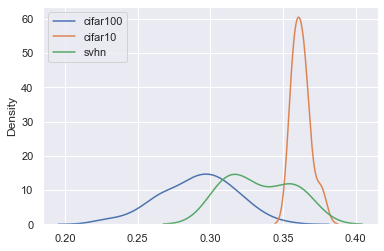

In [6]:
fig, axs = plt.subplots()
sns.kdeplot(mean_cifar100.tolist(), ax=axs)
sns.kdeplot(mean_cifar10.tolist(), ax=axs)
sns.kdeplot(mean_svhn.tolist(), ax=axs)
plt.legend(['cifar100','cifar10','svhn'])
# plt.savefig('VGG16MeanScaled.png',dpi=600)
plt.savefig('ResNetMeanScaled.png',dpi=600)
plt.show()

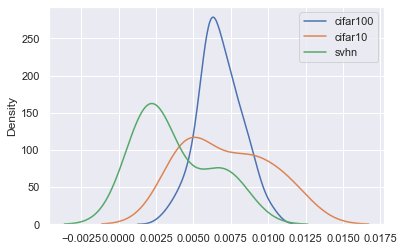

In [7]:
fig, axs = plt.subplots()
sns.kdeplot(std_cifar100.tolist(), ax=axs)
sns.kdeplot(std_cifar10.tolist(), ax=axs)
sns.kdeplot(std_svhn.tolist(), ax=axs)
plt.legend(['cifar100','cifar10','svhn'])
# plt.savefig('VGG16StdScaled.png',dpi=600)
plt.savefig('ResNetStdScaled.png',dpi=600)
plt.show()